<a href="https://colab.research.google.com/github/FilipeSquire/Genome-Project---I2A2/blob/main/Genome_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

O desafio proposta pelo professor é identificar familias através de uma base com read counts de diferentes genes/códigos genéticos para cada pessoa na base. 

**Características da base**
> São 65.215 genes na base e 48 individuos. Não há individuos repetidos ou missing values.

**Proposta de solução**
> O objetivo deste desafio é apresentar um treemap/endograma de cada um desses individuos e as suas respectivas familias. Para realizar tal façanha será necessário identificar os padrões genéticos e compreender a estrutura do gene para realizar clusterizações mais precisas. Além disso, é necessário clusterizar os individuos estabelecendo relação entre os familiares, e se possível, grau de parentesco.

**Principais Problemas Encontrados**
> Durante o desenvolvimento do projeto tive muita dificuldade na fase de entendimento do negócio, nesse caso, o problema e funcionamento de estruturas biológicas do problema. Dado que me falta muito conhecimento relacionado a isso, acredito que a solução encontrada não seja satisfatória.

> Devido a dificuldade para desenvolver o projeto sozinho, devido a falta de conhecimento, trabalhei em conjunto com os colegas de curso, vendo suas soluções e realizando adaptações e/ou melhorias no processo. Vale ressaltar que acredito que a solução não seja satisfatória.

> Um aprendizado importante no desenvolvimento da solução é que se torna nítido a necessidade de termos especialistas de diversas áreas da ciência trabalhando em conjunto para uma solução. Acredito que se o tive e/ou eu pudessemos nos dedicar integralmente ao entendimento do problema do ponto de vista biológico, poderiamos desenvolver uma solução mais robusta.

#Importing and Data Cleaning

First off we have to import the data. On my case I'll be importing from a gsheet file on my gdrive using the code below.

In [ ]:
import pandas as pd 
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default
import gspread
%matplotlib inline

In [ ]:
#Estabelecendo conexão com drive para buscar as credenciais necessarias.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
#Realizando importação dos dados.
gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ksBEAtY-OQw_cpjMk0UJgll8aid516gL5Y8DqJCXRB8')
sheets = gsheets.worksheet('Sheet 1').get_all_values()

gen = pd.DataFrame(sheets[1:],columns=sheets[0])

print('The data shape is {}'.format(gen.shape))
print('The data types are {}'.format(gen.dtypes.unique()))

In [ ]:
#Since there are too many columns, I'll be looking at the dtypes on this simplified way. For a complete look, try gen.info()

print('The old dataframe shape is: {}'.format(gen.shape))

gen.index = gen[''] #setting the genes as index
gen.drop(columns='', inplace=True) #dropping the old columns
gen = gen.astype(int) #chaging dtype from object to int64

print('The new dataframe shape is: {}'.format(gen.shape))

The old dataframe shape is: (65215, 49)
The new dataframe shape is: (65215, 48)


In [ ]:
#Checking if there are null values
# we could use gen.info() but since there is many columns, it would be better for interpretation if we just do a count
gen.isnull().values.sum()
#It seems that there are no null values in our databasea

0

#Data Treatment

Since our database is made of genes (rows) x targets (columns), and all the targets info is actually a gene count for each row and our main objective is to find the families groups, we could delete the genes that has 0 compatibility for all our target variables.

Although this approach is not recommended when dealing with biologic data, I lack the knowledge needed to proceed with more complex (or right) approaches when dealing with this problem.

In [ ]:
gen['count_all'] = gen.sum(axis=1)
gen.head()

,H223,H224,H225,H226,H227,H228,H229,H230,H231,H232,...,H262,H263,H264,H265,H266,H267,H268,H269,H270,count_all
,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,2,0,0,1,0,12
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
ENSG00000000419,1216,1228,1022,912,491,449,466,727,774,576,...,932,360,450,484,926,803,630,537,582,34038
ENSG00000000457,189,114,110,289,186,148,169,258,145,131,...,286,137,90,105,275,101,56,87,81,6547
ENSG00000000460,74,38,55,127,30,17,45,100,33,8,...,157,34,20,15,139,54,25,21,47,2156


Now let's proceed and remove the count_all = 0 from our dataset

In [ ]:
dfcount_zero = gen[gen.count_all == 0].copy()
newgen = gen[gen.count_all != 0].copy()

newgen.drop(columns='count_all', inplace=True)

print('Tamanho original da base é: {}'.format(gen.shape))
print('Novo tamanho da base: {}'.format(newgen.shape))

Tamanho original da base é: (65215, 49)
Novo tamanho da base: (44678, 48)


It looks like we have 20.537 genes with no count for any of our targets (people).

# Distribution Test

Now we must have a look to see if our data is normally distributed, usually I would do this procedure through a graphic analysis but due to our problem with the dimensionality complexity problem, it wouldnt be possible or very useful to do that. Instead I will proceed with a statistical test called **D'Agostino's K-squared test.**.

D'Agostino's K-squared basically combines skew and kurtosis to produce a normality test. It gives the s² + k², where s = z-score returned by skew test and k = z-score returned by kurtosis test and p-value. It works based on an alpha to determine wheter the variables are not normally distributed.


For this test I will use alpha < 0.5 to reject the hypothesis.

**H0 = comes from a normal distribution**

**HA= doesnt comes from a normal distribution**

In [ ]:
from scipy import stats

alpha = 0.5

for x in newgen.columns:
  print([x])
  a,b = stats.normaltest(newgen[[x]])
  print(a,b)

  if b < alpha:
    print(f'The null hypothesis can be rejected for {[x]}')
  else:
    print(f'The null hypothesis cant be rejected for {[x]}')

['H223']
[139921.63507983] [0.]
The null hypothesis can be rejected for ['H223']
['H224']
[126889.7034742] [0.]
The null hypothesis can be rejected for ['H224']
['H225']
[134234.24495543] [0.]
The null hypothesis can be rejected for ['H225']
['H226']
[137101.14340952] [0.]
The null hypothesis can be rejected for ['H226']
['H227']
[145620.37445749] [0.]
The null hypothesis can be rejected for ['H227']
['H228']
[155794.09713177] [0.]
The null hypothesis can be rejected for ['H228']
['H229']
[149865.05959014] [0.]
The null hypothesis can be rejected for ['H229']
['H230']
[127420.2446243] [0.]
The null hypothesis can be rejected for ['H230']
['H231']
[143300.85110764] [0.]
The null hypothesis can be rejected for ['H231']
['H232']
[167790.72959036] [0.]
The null hypothesis can be rejected for ['H232']
['H233']
[143093.54129416] [0.]
The null hypothesis can be rejected for ['H233']
['H234']
[130704.98428992] [0.]
The null hypothesis can be rejected for ['H234']
['H235']
[150393.03389231] [0.

It looks like all our target variables are not normally distributed and it means that we will have to normalize the dataset in order to proceed for the modelling phase. 

But why do we have to normalize our data? If we take a look at it we'll see that the range values are too wide, so we could have rows with a count of 4 and another with 27K. If we normalize our data, we will have all the data with an equal range of values.

#Normalization

Now let's transform the data. Firstly I'll be transposing the dat since the features are on the rows and the variables on the columns.

For this Normalization step I followed the instructions and findings made by Seabra, our fellow colleague. I managed to discover the scanpy library, although I failed to comprehend its implementation and therefore I chose to follow Seabra's choice of normalization.

Seabra decided to use R to have access to the Seurat library which will do the job of normalization for us.

##R Coding

Instead of creating a new code file I will be using using R and Python together. 

If you wanna know more about this implementation, check out the following link:

> [How to use R and Python with Google Colaboratory](https://medium.com/@ezzaouia/how-to-use-r-and-python-with-google-colaboratory-notebook-ebc4774d48a)

In [ ]:
#Setting up the R environment
%load_ext rpy2.ipython

In [ ]:
#Transforming dataframe python to R
%R -i newgen

**WARNING! DONT RUN THE CELL BELOW WITHOUT READING THE COMMENT FIRST ❌**

In [ ]:
%%R
#Downloading Seurat Library. WARNING! The download and installing of this library and all its dependencies took me 20 minutes. Beware before running this cell.
#install.packages('Seurat')

R[write to console]: Attaching SeuratObject



In [ ]:
%%R

library(Seurat)

rgen <- data.frame(NormalizeData(t(newgen))) #Transposing the data and then normalizing it

rgen2 <- rgen[, colSums(rgen != 0)> 0]


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

In [ ]:
#Transforming the R dataframe into Python again
%R -o rgen2

DONE!

In [ ]:
norm_gen = rgen2.copy()
norm_gen.shape

(48, 44678)

#Modelling

In [ ]:
#Deleting the non usable dataframes to free space in our RAM and Disk for the tasks ahead.

del newgen
del rgen2

## K-Means

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sn

Firstly let's run the Elbow Method in order to understand in how many groups we will be breaking our model

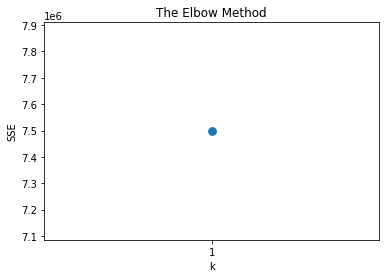

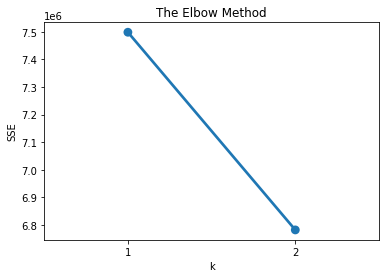

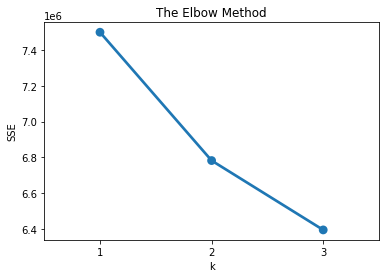

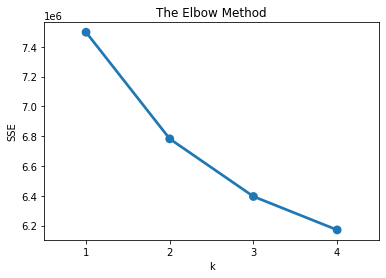

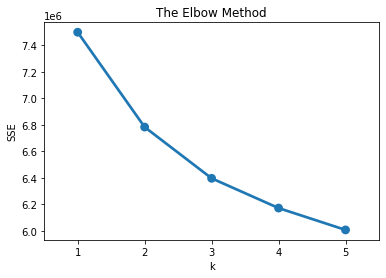

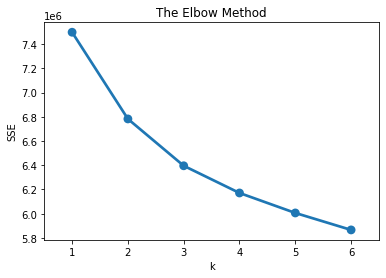

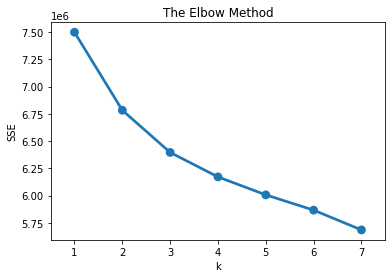

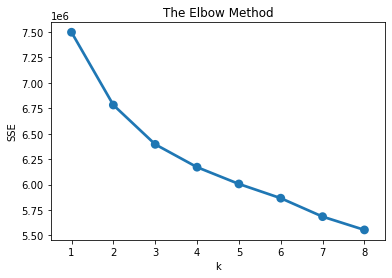

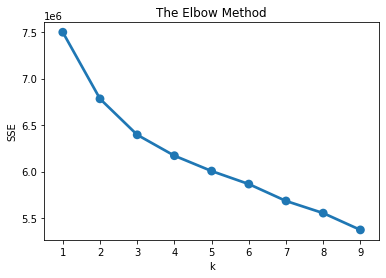

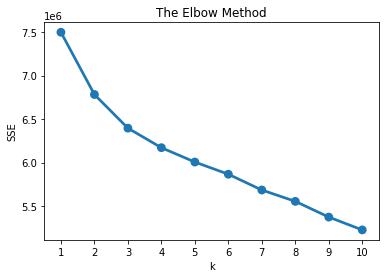

In [ ]:
sse = {}
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(norm_gen)
    sse[k] = kmeans.inertia_ #SSE to closest cluster centroid

    plt.title('The Elbow Method')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sn.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

kmodel = KMeans(n_clusters=3, init='random')
kmodel.fit(norm_gen)

labels = kmodel.labels_

print('Sillhoute Score : {}'.format(silhouette_score(norm_gen, labels, metric='euclidean')))

Sillhoute Score : 0.06299114168671281


In [ ]:
kmeans_cluster = pd.DataFrame(norm_gen, columns = norm_gen.columns, index=norm_gen.index)

kmeans_cluster['family'] = kmodel.labels_

kmeans_cluster.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281892,ENSG00000281896,ENSG00000281899,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281918,ENSG00000281920,family
H223,0.000000,0.0,5.881225,5.668783,5.841305,5.991986,4.472554,5.794610,6.005167,5.874698,...,8.112028,5.757685,0.00000,6.152201,0.0,0.0,5.323408,0.0,0.0,1
H224,0.000000,0.0,5.891018,5.165503,5.177574,5.681517,4.874205,5.725648,7.098597,5.961789,...,0.000000,5.703794,0.00000,0.000000,0.0,0.0,5.323408,0.0,0.0,1
H225,0.000000,0.0,5.707949,5.129993,5.545576,5.860092,0.000000,6.019495,5.895160,5.705528,...,0.000000,5.213436,0.00000,5.566116,0.0,0.0,0.000000,0.0,0.0,1
H226,6.726633,0.0,5.594473,6.092268,6.380214,6.262938,5.563525,6.163107,3.505994,5.464666,...,0.000000,5.948191,0.00000,6.844283,0.0,0.0,6.014114,0.0,0.0,1
H227,0.000000,0.0,4.978460,5.652839,4.942689,5.012682,6.408629,4.083943,3.544529,5.100183,...,0.000000,4.764556,9.21044,6.095167,0.0,0.0,0.000000,0.0,0.0,0


#Dendograma

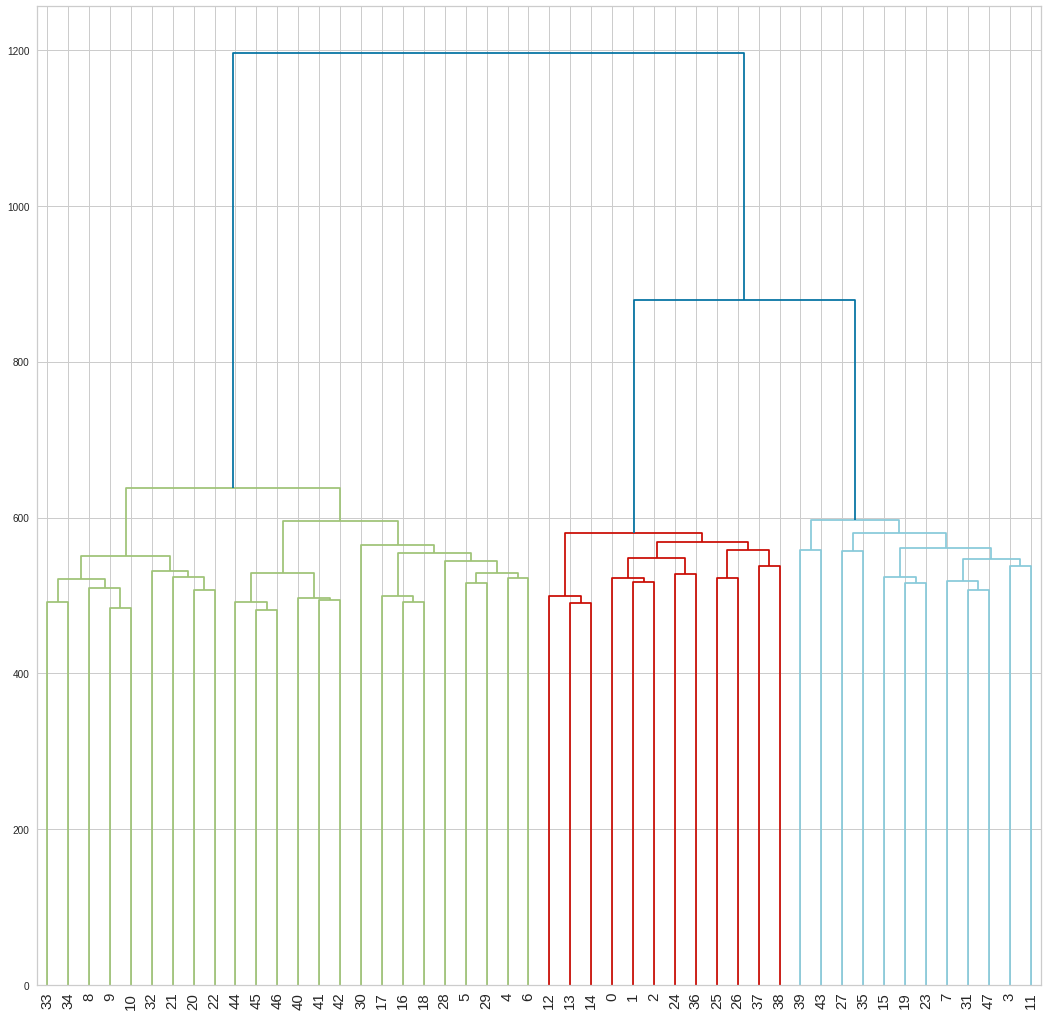


FAMILIA 2 : ['H223' 'H224' 'H225' 'H226' 'H230' 'H234' 'H250' 'H254' 'H258' 'H259'
 'H261' 'H262' 'H266' 'H270']

Total de Parentes encontrados : 14


FAMILIA 1 : ['H227' 'H228' 'H229' 'H231' 'H232' 'H233' 'H239' 'H240' 'H241' 'H243'
 'H244' 'H245' 'H251' 'H252' 'H253' 'H255' 'H256' 'H257' 'H263' 'H264'
 'H265' 'H267' 'H268' 'H269']

Total de Parentes encontrados : 24


FAMILIA 3 : ['H235' 'H236' 'H237' 'H238' 'H242' 'H246' 'H247' 'H248' 'H249' 'H260']

Total de Parentes encontrados : 10



In [ ]:
import scipy.cluster.hierarchy as sch

fig, axes = plt.subplots(1, 0, figsize=(18, 18))
dendogram = sch.dendrogram(sch.linkage(norm_gen, method= 'ward', metric = 'euclidean'), leaf_font_size=15)
plt.show()

#Codigo retirado do Seabra para melhor facilitar o entendimento do endograma. 
for i in norm_gen.family.unique():
  individuos = norm_gen[norm_gen.family == i]
  print(f"\n Family {int(i) + 1} : {individuos.index.values}\n")
  print(f"Parentes encontrados : {len(individuos)}\n")
print("="*140)


In [ ]:
for i in norm_gen.family.unique():
  individuos = norm_gen[norm_gen.family == i]
  print(f"\nFAMILIA {int(i) + 1} : {individuos.index.values}\n")
  print(f"Total de Parentes encontrados : {len(individuos)}\n")
  print("********************".center(140))
print("="*140)


FAMILIA 2 : ['H223' 'H224' 'H225' 'H226' 'H230' 'H234' 'H250' 'H254' 'H258' 'H259'
 'H261' 'H262' 'H266' 'H270']

Total de Parentes encontrados : 14

                                                            ********************                                                            

FAMILIA 1 : ['H227' 'H228' 'H229' 'H231' 'H232' 'H233' 'H239' 'H240' 'H241' 'H243'
 'H244' 'H245' 'H251' 'H252' 'H253' 'H255' 'H256' 'H257' 'H263' 'H264'
 'H265' 'H267' 'H268' 'H269']

Total de Parentes encontrados : 24

                                                            ********************                                                            

FAMILIA 3 : ['H235' 'H236' 'H237' 'H238' 'H242' 'H246' 'H247' 'H248' 'H249' 'H260']

Total de Parentes encontrados : 10

                                                            ********************                                                            
